# Think Bayes solutions: Chapter 4

This notebook presents solutions to exercises in Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

import numpy as np

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite
import thinkplot

%matplotlib inline
import matplotlib.pyplot as plt

## The Euro problem

Here's a class that represents hypotheses about the probability a coin lands heads.

In [2]:
class Euro(Suite):

    def Likelihood(self, data, hypo):
        """Computes the likelihood of `data` given `hypo`.
        
        data: string 'H' or 'T'
        hypo: probability of heads, 0-100
        
        returns: float
        """
        x = hypo
        if data == 'H':
            return x/100
        else:
            return 1 - x/100

We can make a uniform prior and update it with 140 heads and 110 tails:

In [3]:
suite = Euro(range(0, 101))
dataset = 'H' * 140 + 'T' * 110

for data in dataset:
    suite.Update(data)

And here's what the posterior looks like.

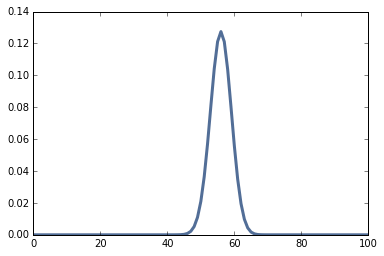

In [4]:
thinkplot.Pdf(suite)

We can summarize the posterior several ways, including the mean:

In [5]:
suite.Mean()

55.952380952380956

Median:

In [6]:
suite.Percentile(50)

56

The peak of the posterior, known as the Maximum Aposteori Probability (MAP)

In [7]:
suite.MAP()

56

And a 90% credible interval

In [8]:
suite.CredibleInterval(90)

(51, 61)

We can look up a particular value in the posterior PMF, but the result doesn't mean much, because we could have divided the range (0-100) into as many pieces as we like, and the result would be different.

In [9]:
suite.Prob(50)

0.02097652612954468

## Different priors

Let's see how that looks with different priors.

Here's a function that makes a uniform prior:

In [10]:
def UniformPrior(label='uniform'):
    """Makes a Suite with a uniform prior."""
    suite = Euro(range(0, 101), label=label)
    return suite

And another that makes a triangular prior.

In [11]:
def TrianglePrior(label='triangle'):
    """Makes a Suite with a triangle prior."""
    suite = Euro(label=label)
    for x in range(0, 51):
        suite[x] = x
    for x in range(51, 101):
        suite[x] = 100-x 
    suite.Normalize()
    return suite

Here's what they look like:

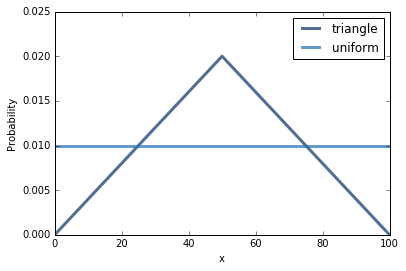

In [12]:
triangle = TrianglePrior()
uniform = UniformPrior()
suites = [triangle, uniform]

thinkplot.Pdfs(suites)
thinkplot.Config(xlabel='x', ylabel='Probability')

If we update them both with the same data:

In [13]:
def RunUpdate(suite, heads=140, tails=110):
    """Updates the Suite with the given number of heads and tails.

    suite: Suite object
    heads: int
    tails: int
    """
    dataset = 'H' * heads + 'T' * tails
    for data in dataset:
        suite.Update(data)

In [14]:
for suite in suites:
    RunUpdate(suite)

The results are almost identical; the remaining difference is unlikely to matter in practice.

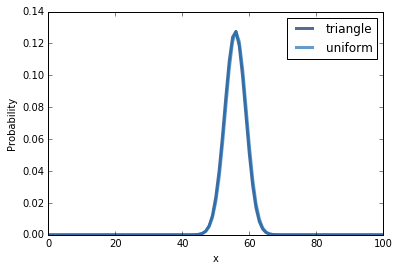

In [15]:
thinkplot.Pdfs(suites)
thinkplot.Config(xlabel='x', ylabel='Probability')

## The binomial likelihood function

We can make the Euro class more efficient by computing the likelihood of the entire dataset at once, rather than one coin toss at a time.

If the probability of heads is p, we can compute the probability of k=140 heads in n=250 tosses using the binomial PMF.

In [16]:
class Euro2(thinkbayes2.Suite):
    """Represents hypotheses about the probability of heads."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: integer value of x, the probability of heads (0-100)
        data: tuple of (number of heads, number of tails)
        """
        x = hypo / 100.0
        heads, tails = data
        like = x**heads * (1-x)**tails
        return like

I left out the binomial coefficient ${n}\choose{k}$ because it does not depend on `p`, so it's the same for all hypotheses.  

In [18]:
suite = Euro2(range(0, 101))
dataset = 140, 110
suite.Update(dataset)

2.6088321798736822e-76

Here's what the posterior looks like.

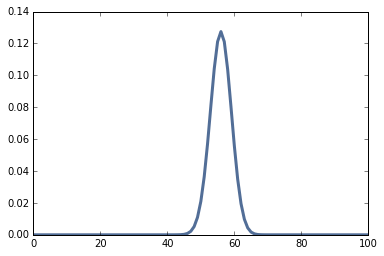

In [19]:
thinkplot.Pdf(suite)

## The Beta distribution

The Beta distribution is a conjugate prior for the binomial likelihood function, which means that if you start with a Beta distribution and update with a binomial likelihood, the posterior is also Beta.

Also, given the parameters of the prior and the data, we can compute the parameters of the posterior directly.  The following class represents a Beta distribution and provides a constant-time Update method.

In [20]:
from scipy import special

class Beta:
    """Represents a Beta distribution.

    See http://en.wikipedia.org/wiki/Beta_distribution
    """
    def __init__(self, alpha=1, beta=1, label=None):
        """Initializes a Beta distribution."""
        self.alpha = alpha
        self.beta = beta
        self.label = label if label is not None else '_nolegend_'

    def Update(self, data):
        """Updates a Beta distribution.

        data: pair of int (heads, tails)
        """
        heads, tails = data
        self.alpha += heads
        self.beta += tails

    def Mean(self):
        """Computes the mean of this distribution."""
        return self.alpha / (self.alpha + self.beta)

    def MAP(self):
        """Computes the value with maximum a posteori probability."""
        a = self.alpha - 1
        b = self.beta - 1
        return a / (a + b)

    def Random(self):
        """Generates a random variate from this distribution."""
        return random.betavariate(self.alpha, self.beta)

    def Sample(self, n):
        """Generates a random sample from this distribution.

        n: int sample size
        """
        size = n,
        return np.random.beta(self.alpha, self.beta, size)

    def EvalPdf(self, x):
        """Evaluates the PDF at x."""
        return x ** (self.alpha - 1) * (1 - x) ** (self.beta - 1)

    def MakePmf(self, steps=101, label=None):
        """Returns a Pmf of this distribution.

        Note: Normally, we just evaluate the PDF at a sequence
        of points and treat the probability density as a probability
        mass.

        But if alpha or beta is less than one, we have to be
        more careful because the PDF goes to infinity at x=0
        and x=1.  In that case we evaluate the CDF and compute
        differences.

        The result is a little funny, because the values at 0 and 1
        are not symmetric.  Nevertheless, it is a reasonable discrete
        model of the continuous distribution, and behaves well as
        the number of values increases.
        """
        if label is None and self.label is not None:
            label = self.label

        if self.alpha < 1 or self.beta < 1:
            cdf = self.MakeCdf()
            pmf = cdf.MakePmf()
            return pmf

        xs = [i / (steps - 1) for i in range(steps)]
        probs = [self.EvalPdf(x) for x in xs]
        pmf = Pmf(dict(zip(xs, probs)), label=label)
        return pmf

    def MakeCdf(self, steps=101):
        """Returns the CDF of this distribution."""
        xs = [i / (steps - 1) for i in range(steps)]
        ps = special.betainc(self.alpha, self.beta, xs)
        cdf = Cdf(xs, ps)
        return cdf

    def Percentile(self, ps):
        """Returns the given percentiles from this distribution.

        ps: scalar, array, or list of [0-100]
        """
        ps = np.asarray(ps) / 100
        xs = special.betaincinv(self.alpha, self.beta, ps)
        return xs
    

Here's how we use it.

In [21]:
beta = Beta()
beta.Update((140, 110))
beta.Mean()

0.5595238095238095

And here's the posterior.

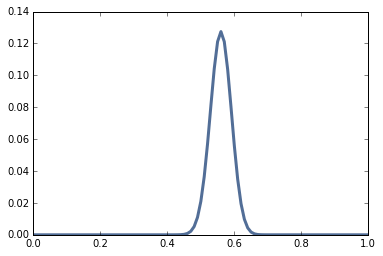

In [22]:
thinkplot.Pdf(beta.MakePmf())

Amazing, no?

**Exercise:** One way to construct priors is to make a Beta distribution and adjust the parameters until it has the shape you want.  Then when you do an update, the data get added to the parameters of the prior.  Since the parameters of the prior play the same mathematical role as the data, they are sometimes called "precounts".

Suppose you believe that most coins are fair or unlikely to deviate from 50% by more than a few percentage points.  Construct a prior that captures this belief and update it with the Euro data.  How much effect does it have on the posterior, compared to the uniform prior?

Hint: A Beta distribution with parameters `(1, 1)` is uniform from 0 to 1.

/notebooks/School/CompBayes F16/ThinkBayes2/code/thinkplot.py:115: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')


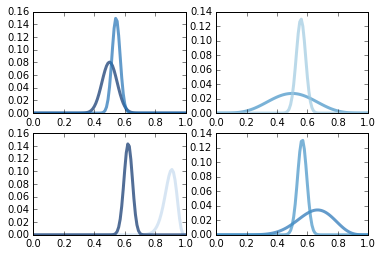

In [23]:
hard_beta = Beta(label="Hard beta (50, 50)")
thinkplot.subplot(1, rows=2, cols=2)
hard_beta.Update((50, 50))
thinkplot.Pdf(hard_beta.MakePmf(), label=hard_beta.label)
hard_beta.Update((140, 110))
thinkplot.Pdf(hard_beta.MakePmf())
thinkplot.subplot(2, rows=2, cols=2)

soft_beta = Beta(label="Soft beta (5, 5)")
soft_beta.Update((5, 5))
thinkplot.Pdf(soft_beta.MakePmf(), label=soft_beta.label)
soft_beta.Update((140, 110))
thinkplot.Pdf(soft_beta.MakePmf())
thinkplot.subplot(3, rows=2, cols=2)

shift_beta = Beta(label="Shift beta (50, 5)")
shift_beta.Update((50, 5))
thinkplot.Pdf(shift_beta.MakePmf(), label=shift_beta.label)
shift_beta.Update((140, 110))
thinkplot.Pdf(shift_beta.MakePmf())
thinkplot.subplot(4, rows=2, cols=2)

shift2_beta = Beta(label="Shift2 beta (10, 5)")
shift2_beta.Update((10, 5))
thinkplot.Pdf(shift2_beta.MakePmf(), label=shift2_beta.label)
shift2_beta.Update((140, 110))
thinkplot.Pdf(shift2_beta.MakePmf())

beta updates being $+$ rule seems true

**Exercise:**  At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match.  They each hit 15 of 25 skeets, sending the match into sudden death.  In the first round, both hit 1 of 2 skeets.  In the next two rounds, they each hit 2 skeets.  Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei?  If the same match were held again, what is the probability that Rhode would win?

As always, you will have to make some modeling decisions, but one approach is to estimate, for each shooter, the probability of hitting a skeet.  Then, to estimate the probability that Rhode is a better shooter, you can draw samples from the two posterior distributions and compare them.  To estimate the probability of winning a rematch, you could draw samples from the posterior distributions and simulate a round of 25 shots.

In [94]:
K_rhode = Beta(22, 11)
W_meng = Beta(21, 12)

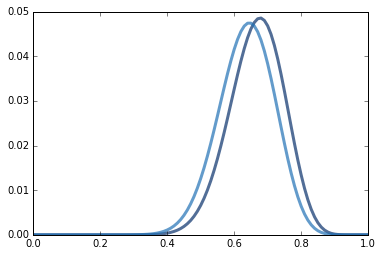

In [95]:
thinkplot.Pdf(K_rhode.MakePmf())
thinkplot.Pdf(W_meng.MakePmf())

In [96]:
better_by = np.mean(K_rhode.Sample(10000) > W_meng.Sample(10000))
better_by

0.60809999999999997

In [122]:
wins = {"K":0,"W":0,"T":0}

In [125]:
K_res = list(map(lambda x: x, K_rhode.Sample(20000)))
W_res = list(map(lambda x: x, W_meng.Sample(20000)))

for k, w in zip(K_res, W_res):
    if k < w:
        wins["W"] += 1
    elif k > w:
        wins["K"] += 1
    elif k == w:
        wins["T"] += 1
    

In [129]:
wins["K"]/(wins["W"]+wins["K"])

0.6076392360763924

**Exercise** Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability `y` that an actual heads is reported as tails, or actual tails reported as heads.

Write a class that estimates the bias of a coin given a series of outcomes and the value of `y`.

How does the spread of the posterior distribution depend on `y`?

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

**Exercise** This exercise is inspired by a question posted by a “redditor” named dominosci on Reddit’s statistics “subreddit” at http://reddit.com/r/statistics.

Reddit is an online forum with many interest groups called subreddits. Users, called redditors, post links to online content and other web pages. Other redditors vote on the links, giving an “upvote” to high-quality links and a “downvote” to links that are bad or irrelevant.

A problem, identified by dominosci, is that some redditors are more reliable than others, and Reddit does not take this into account.

The challenge is to devise a system so that when a redditor casts a vote, the estimated quality of the link is updated in accordance with the reliability of the redditor, and the estimated reliability of the redditor is updated in accordance with the quality of the link.

One approach is to model the quality of the link as the probability of garnering an upvote, and to model the reliability of the redditor as the probability of correctly giving an upvote to a high-quality item.

Write class definitions for redditors and links and an update function that updates both objects whenever a redditor casts a vote.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here